# Deep Learning in Discrete Optimization -- PyTorch Tutorial

**Outline**

1. Installing PyTorch or simply use Google Colab
2. An example on using neural network to predict the connectedness of a six-node graph.
3. Slight modifications to utilize the free GPU.

## 1. Installing PyTorch or simply use Google Colab

-- Installing PyTorch by pip: run the following in terminal "pip3 install torch torchvision" (pip package installer required).

-- An easier way to get started is using Google Colab: https://colab.research.google.com. Most common packages are already pre-installed  on Google Colab including PyTorch. It also provides free GPU (Nvidia Tesla K80) for deep learning tasks.

## 2. An example on using neural network to predict the connectedness of a six-node graph.

The data in "graph6.txt" is a table consisting of 16 columns. The first 15 columns contain the elements of a flatten upper triangular adjacency matrix of the graph where "1" indicates there is an edge between the pair of the nodes (6 choose 2 possible pairs). The last column is the connectedness of the graph where "1" indicates that the graph is connected.

In [0]:
import torch
import torch.nn as nn

Build a three layer neural network for our task. With PyTorch, we only need to specify the forward layers and we get the backpropgation for free.

In [0]:
class My_Net(nn.Module): 
    def __init__(self, input_size, num_neurons):
        super(My_Net, self).__init__()
        #feed forward layers
        self.layer_1 = nn.Linear(input_size, num_neurons)
        self.layer_2 = nn.Linear(num_neurons, num_neurons)
        self.layer_3 = nn.Linear(num_neurons, 1)

        #activations
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid() #Use sigmoid to convert the output into range (0,1)
        
    def forward(self, input_data):
        out = self.layer_1(input_data)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.layer_3(out)
        out = self.sigmoid(out).view(-1)
        return out

In [0]:
#10 neurons for each hidden layers
net=My_Net(input_size=15, num_neurons=10)

#Standard cross entropy loss for classification tasks
loss=nn.BCELoss()

#Define the optimizer. Here we use Adam optimizer.
opt=torch.optim.Adam(net.parameters(),lr=0.01)

Load the data into tensors.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

On Google Colab, the data files need to be uploaded to the cloud. Simply use the "Files -- Upload" on the left of the page to do a one-time upload. If you don't want to upload it everytime you use it, then upload the file to your Google Drive and use the "Files --  Mount Drive" to mount your google drive to the jupyter notebook.

In [0]:
data = np.array(pd.read_table("graphs6.txt", delimiter=' ', header=None),dtype=int)
Xdata = data[:,:-1]
Ydata = data[:,-1]

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.5)

In [7]:
np.shape(X_train)

(16384, 15)

In [0]:
Xtrain = torch.Tensor(X_train)
Xtest = torch.Tensor(X_test)
ytrain = torch.Tensor(y_train)
ytest = torch.Tensor(y_test)

Load the data into dataloaders(batches) for stochastic gradient descent.

In [0]:
train = torch.utils.data.TensorDataset(Xtrain, ytrain)
test = torch.utils.data.TensorDataset(Xtest, ytest)

train_loader = torch.utils.data.DataLoader(train, batch_size=128,num_workers=2)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False,num_workers=2)

Define the training and the testing function.

In [0]:
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    num_batches = 0
    for inputs, labels in train_loader:
        outputs = net(inputs)
        predicted = outputs.data>0.5
        total += labels.size(0)
        correct += (predicted.int() == labels.int()).sum()
        loss_sum  += loss(outputs,labels).item()
        num_batches += 1

    if verbose:
        print('Train accuracy: %f %%' % (100 * correct.item() / total))
    return loss_sum/num_batches, correct.item() / total

def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    num_batches = 0
    for inputs, labels in test_loader:
        outputs = net(inputs)
        predicted = outputs.data>0.5
        total += labels.size(0)
        correct += (predicted.int() == labels.int()).sum()
        loss_sum  += loss(outputs,labels).item()
        num_batches += 1

    if verbose:
        print('Test accuracy: %f %%' % (100 * correct.item() / total))
    return loss_sum/num_batches, correct.item() / total

Train the network and report  the training loss/accuracy.

In [11]:
#initialize the network using Xavier initialization.
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)

net.apply(weights_init)

My_Net(
  (layer_1): Linear(in_features=15, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [12]:
import time

epochs=25;
train_loss_store = []
train_acc_store = []
test_loss_store = []
test_acc_store = []


for epoch in range(epochs):
    time1=time.time()
    print('In epoch %i : '%(epoch+1))
    for i, (x,y) in enumerate(train_loader,0):
        #set the gradients to zero initially for each batch
        opt.zero_grad()
        outputs = net(x)
        l=loss(outputs, y)
        l.backward()
        opt.step()
    
    l_temp, acc_temp = train_eval()
    train_loss_store.append(l_temp)
    train_acc_store.append(acc_temp)

    l_temp, acc_temp = test_eval()
    test_loss_store.append(l_temp)
    test_acc_store.append(acc_temp)

    time2=time.time()
    print("Time lapse: %f secs" %round((time2-time1),2))

In epoch 1 : 
Train accuracy: 88.653564 %
Test accuracy: 88.629150 %
Time lapse: 1.140000 secs
In epoch 2 : 
Train accuracy: 90.521240 %
Test accuracy: 89.807129 %
Time lapse: 1.070000 secs
In epoch 3 : 
Train accuracy: 91.564941 %
Test accuracy: 90.594482 %
Time lapse: 1.060000 secs
In epoch 4 : 
Train accuracy: 92.016602 %
Test accuracy: 91.180420 %
Time lapse: 1.090000 secs
In epoch 5 : 
Train accuracy: 93.115234 %
Test accuracy: 92.675781 %
Time lapse: 1.040000 secs
In epoch 6 : 
Train accuracy: 94.445801 %
Test accuracy: 93.945312 %
Time lapse: 1.060000 secs
In epoch 7 : 
Train accuracy: 94.836426 %
Test accuracy: 94.537354 %
Time lapse: 1.080000 secs
In epoch 8 : 
Train accuracy: 95.227051 %
Test accuracy: 94.952393 %
Time lapse: 1.080000 secs
In epoch 9 : 
Train accuracy: 95.532227 %
Test accuracy: 95.294189 %
Time lapse: 1.060000 secs
In epoch 10 : 
Train accuracy: 95.703125 %
Test accuracy: 95.654297 %
Time lapse: 1.120000 secs
In epoch 11 : 
Train accuracy: 95.996094 %
Test a

Visualize the training and testing loss/accuracy.

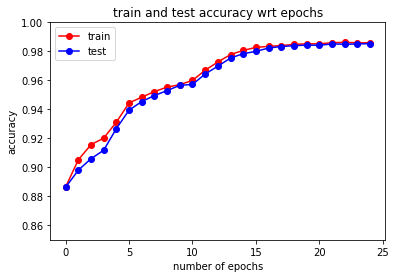

In [13]:
plt.plot(train_acc_store,'r-o')
plt.plot(test_acc_store,'b-o')
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.ylim(0.85,1)
plt.legend(('train','test'),loc='upper left')
plt.title('train and test accuracy wrt epochs')
plt.show()

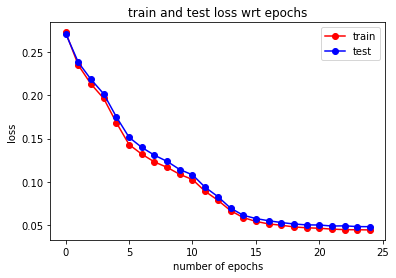

In [14]:
plt.plot(train_loss_store,'r-o')
plt.plot(test_loss_store,'b-o')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend(('train','test'),loc='upper right')
plt.title('train and test loss wrt epochs')
plt.show()

## 3. Slight modifications to utilize the free GPU
Enable the GPU by changing the runtime to a GPU runtime. Click "Runtime" on the top of the page, then "change runtime type -- Hardware accelerator -- GPU".

In [15]:
#check if GPU is available
gpu_boole = torch.cuda.is_available()
print("Is GPU available for use?     " + str(gpu_boole))

Is GPU available for use?     True


In [0]:
#redefine the net to cuda gpu

net=My_Net(input_size=15, num_neurons=10)
if gpu_boole: 
    net=net.cuda()

#Standard cross entropy loss for classification tasks
loss=nn.BCELoss()

#Define the optimizer. Here we use Adam optimizer.
opt=torch.optim.Adam(net.parameters(),lr=0.01)

In [0]:
#inputs need to be redefined accordingly
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    num_batches = 0
    for inputs, labels in train_loader:
        #send inputs to cuda
        if gpu_boole:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        predicted = outputs.data>0.5
        total += labels.size(0)
        correct += (predicted.int() == labels.int()).sum()
        loss_sum  += loss(outputs,labels).item()
        num_batches += 1

    if verbose:
        print('Train accuracy: %f %%' % (100 * correct.item() / total))
    return loss_sum/num_batches, correct.item() / total

def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    num_batches = 0
    for inputs, labels in test_loader:
        #send inputs to cuda
        if gpu_boole:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        predicted = outputs.data>0.5
        total += labels.size(0)
        correct += (predicted.int() == labels.int()).sum()
        loss_sum  += loss(outputs,labels).item()
        num_batches += 1

    if verbose:
        print('Test accuracy: %f %%' % (100 * correct.item() / total))
    return loss_sum/num_batches, correct.item() / total

In [18]:
import time

net.apply(weights_init)

epochs=25;
train_loss_store = []
train_acc_store = []
test_loss_store = []
test_acc_store = []


for epoch in range(epochs):
    time1=time.time()
    print('In epoch %i : '%(epoch+1))
    for i, (x,y) in enumerate(train_loader,0):
        #send inputs to cuda
        if gpu_boole:
            x, y = x.cuda(), y.cuda()
        #set the gradients to zero initially for each batch
        opt.zero_grad()
        outputs = net(x)
        l=loss(outputs, y)
        l.backward()
        opt.step()
    
    l_temp, acc_temp = train_eval()
    train_loss_store.append(l_temp)
    train_acc_store.append(acc_temp)

    l_temp, acc_temp = test_eval()
    test_loss_store.append(l_temp)
    test_acc_store.append(acc_temp)

    time2=time.time()
    print("Time lapse: %f secs" %round((time2-time1),2))

In epoch 1 : 
Train accuracy: 89.117432 %
Test accuracy: 88.262939 %
Time lapse: 1.390000 secs
In epoch 2 : 
Train accuracy: 91.656494 %
Test accuracy: 91.564941 %
Time lapse: 1.350000 secs
In epoch 3 : 
Train accuracy: 94.226074 %
Test accuracy: 94.024658 %
Time lapse: 1.380000 secs
In epoch 4 : 
Train accuracy: 96.118164 %
Test accuracy: 95.849609 %
Time lapse: 1.420000 secs
In epoch 5 : 
Train accuracy: 97.912598 %
Test accuracy: 97.863770 %
Time lapse: 1.340000 secs
In epoch 6 : 
Train accuracy: 98.400879 %
Test accuracy: 98.278809 %
Time lapse: 1.360000 secs
In epoch 7 : 
Train accuracy: 98.406982 %
Test accuracy: 98.315430 %
Time lapse: 1.330000 secs
In epoch 8 : 
Train accuracy: 98.254395 %
Test accuracy: 98.278809 %
Time lapse: 1.370000 secs
In epoch 9 : 
Train accuracy: 98.120117 %
Test accuracy: 98.028564 %
Time lapse: 1.440000 secs
In epoch 10 : 
Train accuracy: 98.242188 %
Test accuracy: 98.126221 %
Time lapse: 1.350000 secs
In epoch 11 : 
Train accuracy: 98.339844 %
Test a

Remarks: For this problem, the data size is rather small and the inputs are not images so doing all the computation on CPU is even faster than on GPU. If a specific task requires processing images or computing convolutions then it may be preferable to work on a GPU.